In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

from scipy import constants as c
c.Msun = 1.989e30

from pycbc import fft, types
from pycbc.waveform import get_fd_waveform, get_td_waveform, fd_approximants, apply_fd_time_shift
from pycbc.waveform.utils import fd_to_td

from copy import deepcopy
import joblib

import sys
sys.path.append("../")
import GSHEWaveform

# Functions to turn on and off custom plotting
def default_mplstyle():
    mpl.rcParams.update(mpl.rcParamsDefault)
    
def custom_mplstyle():
    mpl.style.use("../plot_style.txt")
    
def ylabel_with_offset(ax, label):
    ax.yaxis.offsetText.set_visible(False)
    offset = ax.yaxis.get_major_formatter().get_offset()
    ax.set_ylabel(r"{} {}".format(label, offset))
    
%load_ext autoreload
%autoreload 2

In [269]:
f_min = 40
f_max = 512
M = 5e4

<IPython.core.display.Javascript object>


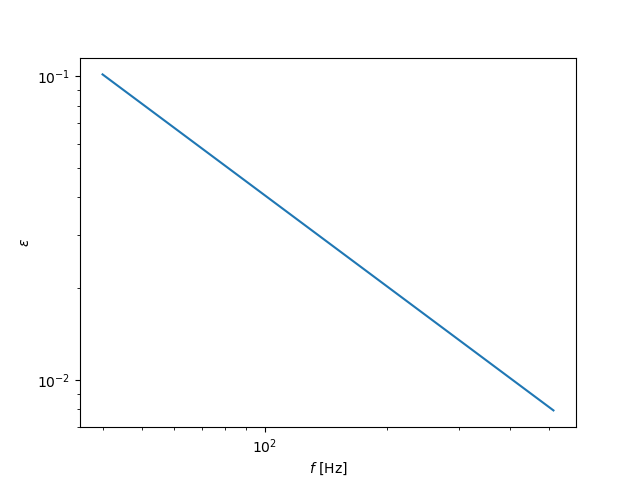

In [270]:
fs = np.linspace(f_min, f_max, 1000)

plt.figure()
plt.plot(fs, GSHEWaveform.epsilon_from_freq(fs, M))
plt.yscale("log")
plt.xscale("log")
plt.xlabel(r"$f~[\mathrm{Hz}]$")
plt.ylabel(r"$\epsilon$")
plt.show()

In [271]:
waveform_params = {"approximant": "IMRPhenomXP", "mass1": 50, "mass2": 50, "spin1z": 0.7,
                   "inclination": 0.9*np.pi}

delta_f = 0.001
left_taper = 0
right_taper = 0

left_window = (f_min - left_taper, f_min)
right_window = (f_max, f_max + right_taper)

fhplus, fhcross = get_fd_waveform(**waveform_params, delta_f=delta_f, f_lower=f_min - left_taper,
                                  f_final=f_max+right_taper)

In [272]:
plus_data = np.stack([fhplus.sample_frequencies.data, fhplus.data.real, fhplus.data.imag])
cross_data = np.stack([fhcross.sample_frequencies.data, fhcross.data.real, fhcross.data.imag])

In [273]:
wf = np.stack([plus_data, cross_data])
m = (wf[0, 0, :] > 40) & (wf[0, 0, :] < 512)

wf = wf[..., m]
np.save("/Users/richard/Downloads/waveform.npy", wf)

In [274]:
wf.shape

(2, 3, 471999)

In [275]:
wf.shape

(2, 3, 471999)

In [276]:
fhright, fhleft = GSHEWaveform.linear_to_circular(fhplus, fhcross)


# rdelay = lambda f: GSHEWaveform.time_delay_analytical(
#     f, M, GSHEWaveform.coordinate_time_to_seconds(2, M), 2.0)

rdelay = GSHEWaveform.GSHEtoGeodesicDelayInterpolator(epsilons, Xgshe, Xgeo, n, s=0, M=M)

In [295]:
mixing = GSHEWaveform.mixing(fhright.sample_frequencies.data, rdelay(fhright.sample_frequencies))

fhright_gshe = mixing * fhright

from scipy.interpolate import interp1d

from scipy.integrate import quad

In [296]:
f1 = interp1d(fhright.sample_frequencies.data, np.real(fhright_gshe.data * fhright.data.conj()))

f2 = interp1d(fhright.sample_frequencies.data, np.real(fhright.data * fhright.data.conj()))

In [297]:
(1 - quad(f1, 40, 512)[0] / quad(f2, 40, 512)[0]) * 100

0.7648030439906917

In [280]:
A = fhplus.conj() * fhplus

In [281]:
from scipy.integrate import quad
from scipy.interpolate import interp1d

from scipy import constants as c

In [282]:
func1 = interp1d(A.sample_frequencies, np.real(A.data) / A.sample_frequencies**2)
func2 = interp1d(A.sample_frequencies, np.real(A.data))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pycbc/types/array.py:213: RuntimeWarning: invalid value encountered in true_divide
  ret = getattr(ufunc, method)(*inputs, **kwargs)


In [283]:
Msun = 1.9885e30
M = 5e4 * Msun

Rs = 2 * c.G * M  / c.c**2 

M = 0.5 * (4 * np.pi * c.c / Rs)**2 * quad(func1, 40, 512)[0] / quad(func2, 40, 512)[0]


beta = 0.1

print(beta**2 * M * 100)


M = 5e4

0.0851617590441642


In [284]:
# beta = 0.1

# (beta * 4 * np.pi * c.c / Rs / 40)**4

In [285]:
# plt.figure()
# plt.plot(A.sample_frequencies, A / A.sample_frequencies**2)
# plt.plot(A.sample_frequencies, A)
# plt.yscale('log')
# plt.xlim(20, 600)
# plt.xlabel("freq")
# plt.ylabel("Amplitude")

# # plt.savefig("/Users/richard/Downloads/amplitude.png", dpi=300)
# plt.show()

In [286]:
# from scipy.interpolate import interp1d
# from scipy.integrate import quad

# f1 = interp1d(A.sample_frequencies.data, A.data / A.data.sample_frequencies**2)

Functions that calculate the time delay for a given frequency. For now assume a simple analytic expression (power law). Later take data and interpolate between sampled data points.

In [287]:
runID = "01"

Xgeos = np.load("../data/{}Xgeos.npy".format(runID))
Xgshes = np.load("../data/{}Xgshes.npy".format(runID))
vary_param = np.load("../data/{}VaryParam.npy".format(runID))
epsilons = np.load("../data/{}Epsilons.npy".format(runID))

k = np.abs(vary_param - 0.4*np.pi).argmin()

Xgeo = Xgeos[k, ...]
Xgshe = Xgshes[k, ...]

In [288]:
n = 0
# rdelay = GSHEWaveform.GSHEtoGeodesicDelayInterpolator(epsilons, Xgshe, Xgeo, n, s=0, M=M)
# ldelay = GSHEWaveform.GSHEtoGeodesicDelayInterpolator(epsilons, Xgshe, Xgeo, n, s=1, M=M)

rdelay = lambda f: GSHEWaveform.time_delay_analytical(
    f, M, GSHEWaveform.coordinate_time_to_seconds(0.3, M), 2.0)
ldelay = lambda f: GSHEWaveform.time_delay_analytical(
    f, M, GSHEWaveform.coordinate_time_to_seconds(0.3, M), 2.0)

<IPython.core.display.Javascript object>


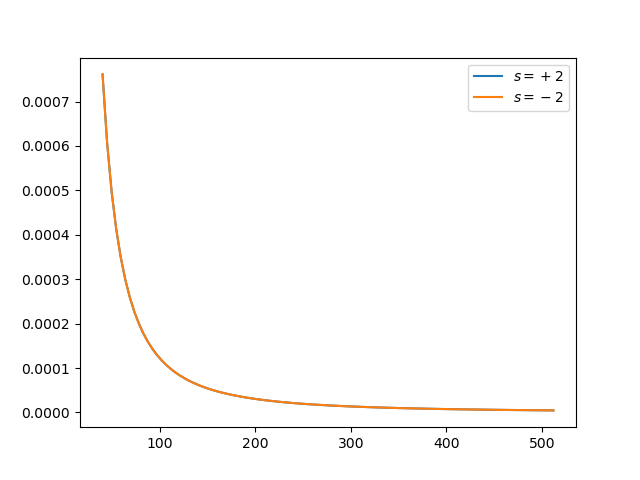

In [289]:
default_mplstyle()

fs = np.linspace(f_min, f_max, 100)
plt.figure()
plt.plot(fs, rdelay(fs), label=r"$s=+2$")
plt.plot(fs, ldelay(fs), label=r"$s=-2$")

# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.show()

Apply the GSHE corrections to the generated waveform in the frequency domain

In [290]:
fhplus_gshe, fhcross_gshe = GSHEWaveform.gshe_to_linear(fhplus, fhcross, rdelay, ldelay)

In [292]:
(1 - optimized_match(fhplus, fhplus_gshe, low_frequency_cutoff=40)[0])

0.00013778174790091136

Inverse Fourier transform to the time domain

In [293]:
# Plus polarisation
thplus = GSHEWaveform.fd_to_td_fiducialshift(fhplus, left_window, right_window)
thplus_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhplus_gshe, left_window, right_window)

# Cross polarisation
thcross = GSHEWaveform.fd_to_td_fiducialshift(fhcross, left_window, right_window)
thcross_gshe = GSHEWaveform.fd_to_td_fiducialshift(fhcross_gshe, left_window, right_window)

ValueError: initial_array must contain at least one sample.

# Plot of the + polarisation state

<IPython.core.display.Javascript object>


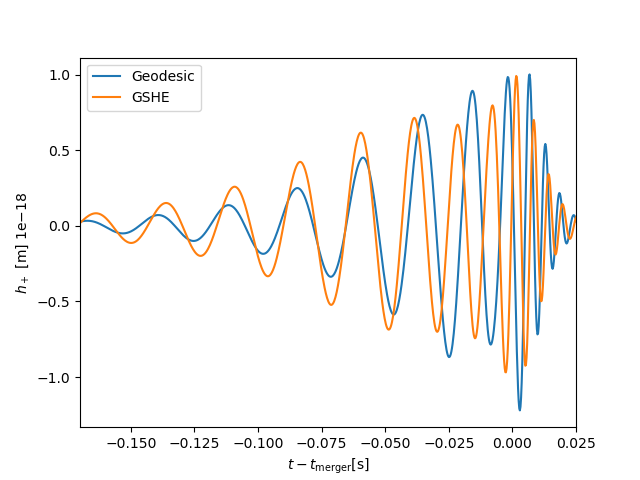

In [294]:
default_mplstyle()

fig, ax = plt.subplots()

ax.plot(thplus.sample_times, thplus.data, label="Geodesic")
ax.plot(thplus_gshe.sample_times, thplus_gshe.data, label="GSHE")

plt.savefig("/Users/richard/Downloads/_tmp.png")

ax.legend()
ax.set_xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")
ax.set_ylabel(r"$h_{\rm +} [\mathrm{m}]$")
ax.set_xlim(-0.17, 0.025)
ylabel_with_offset(ax, r"$h_{\rm +}~[\mathrm{{m}}]$")
# plt.savefig("/Users/richard/Downloads/hp_example.pdf", bbox_inches="tight")
fig.show()

In [23]:
from pycbc.filter.matchedfilter import optimized_match, match

In [28]:
(1 - optimized_match(fhplus, fhplus_gshe)[0])

0.2524354027623077

In [20]:
out = {"thplus": thplus,
      "thcross": thcross,
      "thplus_gshe": thplus_gshe,
      "thcross_gshe": thcross_gshe}

joblib.dump(out, "../data/light_merger.z")

['../data/light_merger.z']

# Strain plot

<IPython.core.display.Javascript object>


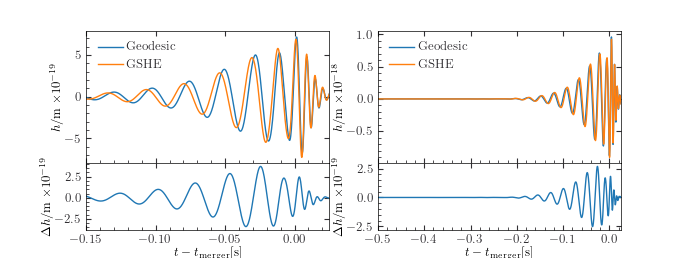

In [21]:
Fplus = -0.38
Fcross = 0.71


custom_mplstyle()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(3.45*2, 0.75*3.45),
                         sharex='col',  gridspec_kw={'height_ratios': [1, 0.5]})
fig.subplots_adjust(hspace=0.0, wspace=0.2)


for i, kind in enumerate(["heavy_merger", "light_merger"]):
    data = joblib.load("../data/{}.z".format(kind))
    thplus = data["thplus"]
    thcross = data["thcross"]
    thplus_gshe = data["thplus_gshe"]
    thcross_gshe = data["thcross_gshe"]
    strain = GSHEWaveform.waveform_to_strain(thplus, thcross, Fplus, Fcross)
    strain_gshe = GSHEWaveform.waveform_to_strain(thplus_gshe, thcross_gshe, Fplus, Fcross)

    axes[0, i].plot(strain.sample_times, strain, label="Geodesic")
    axes[0, i].plot(strain_gshe.sample_times, strain_gshe, label="GSHE")
    axes[1, i].plot(strain.sample_times, strain - strain_gshe)




plt.savefig("/Users/richard/Downloads/_tmp.png")

axes[1, 0].set_xlim(-0.15, 0.025) 
axes[1, 1].set_xlim(-0.5, 0.025)


for i in range(2):
    axes[1, i].set_xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")
    ylabel_with_offset(axes[0, i], r"$h / \mathrm{m}$")
    ylabel_with_offset(axes[1, i], r"$\Delta h / \mathrm{m}$")
    axes[0,i].legend()

plt.savefig("/Users/richard/Downloads/strains.pdf", dpi=300, bbox_inches="tight")
plt.show()

<IPython.core.display.Javascript object>


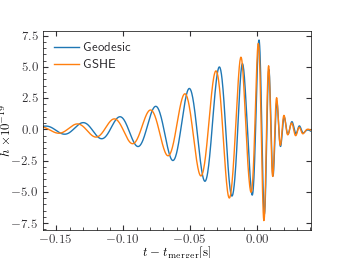

In [22]:
fig, ax = plt.subplots()


data = joblib.load("../data/{}.z".format("heavy_merger"))
thplus = data["thplus"]
thcross = data["thcross"]
thplus_gshe = data["thplus_gshe"]
thcross_gshe = data["thcross_gshe"]
strain = GSHEWaveform.waveform_to_strain(thplus, thcross, Fplus, Fcross)
strain_gshe = GSHEWaveform.waveform_to_strain(thplus_gshe, thcross_gshe, Fplus, Fcross)

ax.plot(strain.sample_times, strain, label="Geodesic")
ax.plot(strain_gshe.sample_times, strain_gshe, label="GSHE")

ax.set_xlim(-0.16, 0.04) 

plt.savefig("/Users/richard/Downloads/_tmp.png")

ax.set_xlabel(r"$t - t_{\rm merger} [\mathrm{s}]$")
ylabel_with_offset(ax, r"$h$")


ax.legend()


plt.savefig("/Users/richard/Downloads/strain.pdf", bbox_inches="tight")
fig.show()

In [ ]:
match(fhplus, fhplus_gshe)

In [ ]:
fhplus.delta_f

In [ ]:
from pycbc.detector import Detector, get_available_detectors

In [ ]:
from pycbc.filter.matchedfilter import optimized_match, match
from pycbc.psd import analytical

In [ ]:
psd = analytical.CosmicExplorerWidebandP1600143(fhplus.sample_frequencies.data.size, fhplus.delta_f, 40)

In [ ]:
optimized_match(fhplus, fhplus_gshe)

In [ ]:
match(strain, strain_gshe)